In [1]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
# read the image, resize to 224 and convert to PyTorch Tensor
image = Image.open("kopje.jpg")

# Standard normalization values for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
   transforms.Normalize(mean, std)
])

# add batch dimension
image_tensor = preprocess(image).unsqueeze(0)

image_variable = Variable(image_tensor, requires_grad=True)

In [3]:
def show_image(image_variable, pred_label, prob):
    # remove batch dimension
    img = image_variable.squeeze(0)
    
    # Undo normalizations
    img = img.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()

    # Convert C X H X W -->  H X W X C
    img = np.transpose(img, (1,2,0))   
    img = np.clip(img, 0, 1)
    
    figure, ax = plt.subplots(1,1, figsize=(4,4))
    
    ax.imshow(img)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    
    ax.text(0.5, -0.2,
            'Prediction: {}\n Probability: {:.4f}'.format(pred_label, prob),
            size=12, ha="center", transform=ax.transAxes)
    
    plt.show()
    

In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();


In [5]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

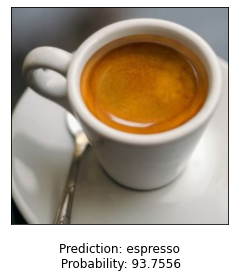

In [6]:
pred = model(image_variable)

pred_label = imagenet_classes[pred.max(dim=1)[1].item()]
probs = F.softmax(pred, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(image_variable, pred_label, prob)


In [7]:
y_true = 967
epsilon = 0.4

pred = model(image_variable)

model.zero_grad()

loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_true]))

loss.backward(retain_graph=True)

perturbed_image = image_variable + epsilon * image_variable.grad.data.sign()

pred_perturbed = model(perturbed_image)

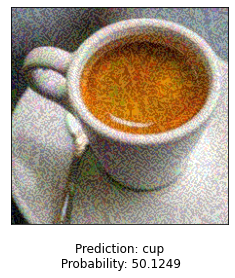

In [8]:
pred_label = imagenet_classes[pred_perturbed.max(dim=1)[1].item()]
probs = F.softmax(pred_perturbed, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(perturbed_image, pred_label, prob)

# One step target class

In [9]:
# find least likely class
pred = model(image_variable)
y_target = torch.argmin(pred).item()
print('least likely class: {}'.format(imagenet_classes[y_target]))

epsilon = 0.4

pred = model(image_variable)

model.zero_grad()

loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_target]))

loss.backward(retain_graph=True)

perturbed_image = image_variable - epsilon * image_variable.grad.data.sign()

pred_perturbed = model(perturbed_image)

least likely class: dam


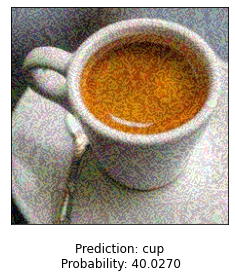

In [10]:
pred_label = imagenet_classes[pred_perturbed.max(dim=1)[1].item()]
probs = F.softmax(pred_perturbed, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(perturbed_image, pred_label, prob)

# Basic iterative method attack

In [39]:
y_true = 967
epsilon = 0.1
alpha = .25
num_steps = 3

for i in range(num_steps):
    
    pred = model(image_variable)

    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_true]))
    
    loss.backward()
        
    adv_temp = image_variable.data + alpha * image_variable.grad.data.sign()
    
    total_grad = adv_temp - image_tensor
    
    total_grad = total_grad.data.clamp(-epsilon, epsilon)
    
    image_variable.data = image_tensor + total_grad


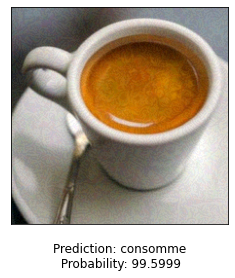

In [40]:
pred = model(image_variable)

pred_label = imagenet_classes[pred.max(dim=1)[1].item()]
probs = F.softmax(pred, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(image_variable, pred_label, prob)


In [43]:
# reset the gradients
image_variable.grad.data.zero_()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

# Iterative leasy-likely class method

In [46]:
# find least likely class
pred = model(image_variable)
y_target = torch.argmin(pred).item()
print('least likely class: {}'.format(imagenet_classes[y_target]))

epsilon = 0.2
alpha = 0.025
num_steps = 7

for i in range(num_steps):
    
    pred = model(image_variable)

    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([y_target]))
    
    loss.backward()
        
    adv_temp = image_variable.data - alpha * image_variable.grad.data.sign()
    
    total_grad = adv_temp - image_tensor
    
    total_grad = total_grad.data.clamp(-epsilon, epsilon)
    
    x_adv = image_tensor + total_grad
    
    image_variable.data = x_adv


least likely class: tiger_beetle


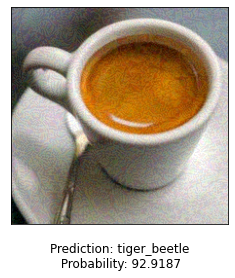

In [47]:
pred = model(image_variable)

pred_label = imagenet_classes[pred.max(dim=1)[1].item()]
probs = F.softmax(pred, dim=1)
prob = torch.max(probs.data, 1)[0][0] * 100

# plot image
show_image(image_variable, pred_label, prob)
